In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [2]:
def read_data(fn):
    data = pd.read_csv(fn)
    data["Dates"] = ""
    data["time_rs"] = 0.0

    for i in range(data.shape[0]):
        dt = datetime.fromtimestamp(data.iloc[i]['timestamp'] // 1000)
        data.at[i, 'Dates'] = dt

        m = (data.iloc[i]['sunset'] + data.iloc[i]['sunrise']) // 2

        if data.iloc[i]['timestamp'] < m:
            time_rs = (data.iloc[i]['timestamp'] - data.iloc[i]['sunrise']) / \
            (m - data.iloc[i]['sunrise'])
        else:
            time_rs = (data.iloc[i]['sunset'] - data.iloc[i]['timestamp']) / \
            (data.iloc[i]['sunset'] - m)

        data.at[i, 'time_rs'] = time_rs

    data = data.set_index('Dates')
    data = data.drop(['timestamp','sunrise','sunset'], axis=1) 

    cols = list(data.columns)
    a, b = cols.index('pwr'), cols.index('time_rs')
    cols[b], cols[a] = cols[a], cols[b]
    data = data[cols]
    
    return data

In [25]:
df = read_data('all_owm.csv')

data_X = df.drop('pwr', axis = 1)
data_Y = df.pwr

split_idx = int(data_X.shape[0] * 0.7)
X_train = data_X[:split_idx]
y_train = data_Y[:split_idx]
X_test = data_X[split_idx:]
y_test = data_Y[split_idx:]

In [7]:
from statsmodels.regression import linear_model

In [8]:
olsr_results = linear_model.OLS(y_train, X_train).fit()

y_hat = olsr_results.predict(X_test)

olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    pwr   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              2546.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):                        0.00
Time:                        13:50:43   Log-Likelihood:                         -20275.
No. Observations:                4317   AIC:                                  4.056e+04
Df Residuals:                    4311   BIC:                                  4.060e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.6323      0.079      8.039      0.000       0.478       0.787
humidity       0.0493      0.022      2.206      0.027       0.005       0.093
rain           1.0032      4.401      0.228      0.820      -7.626       9.632
cloud         -0.0322      0.015     -2.213      0.027      -0.061      -0.004
visibility     0.1243      0.031      3.956      0.000       0.063       0.186
time_rs       61.6592      0.746     82.677      0.000      60.197      63.121
==============================================================================
Omnibus:                      167.835   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.525
Skew:                           0.018   Prob(JB):                     1.08e-16
Kurtosis:                       2.362   Cond. No.                     1.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Predicted')

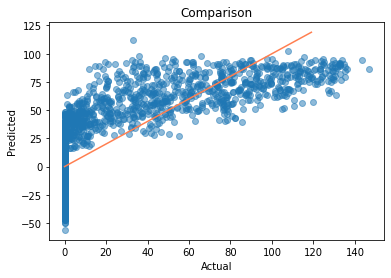

In [9]:
x = np.arange(120)
plt.plot(x,x,color='coral')

plt.scatter(y_test, y_hat, alpha=0.5)
plt.title('Comparison')
plt.xlabel('Actual')
plt.ylabel('Predicted')

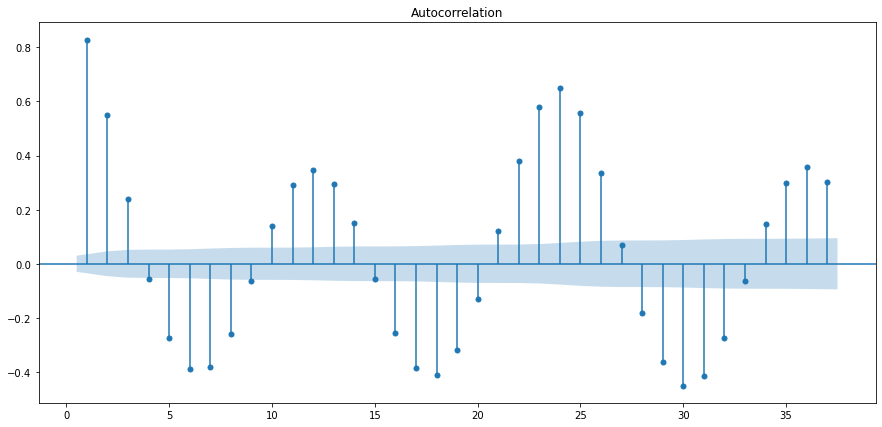

In [10]:
import statsmodels.graphics.tsaplots as tsa

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_results.resid, alpha=0.05, zero=False, ax=ax)

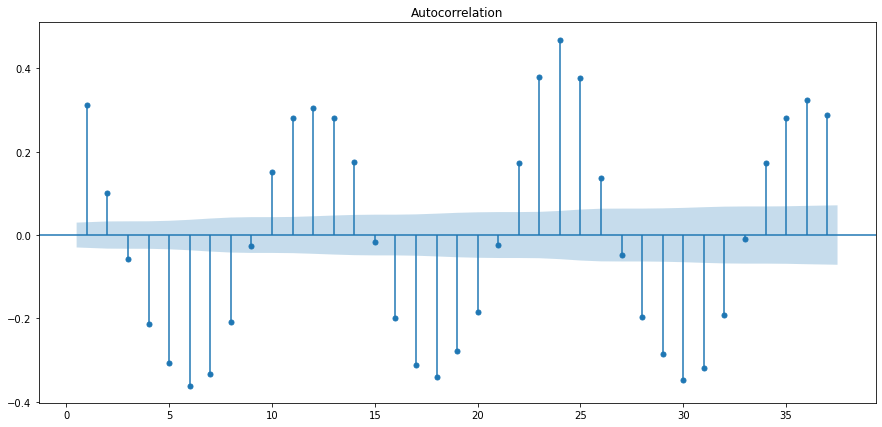

In [11]:
olsr_resid_diff_1 = olsr_results.resid.diff()
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_1, alpha=0.05, zero=False, ax=ax)

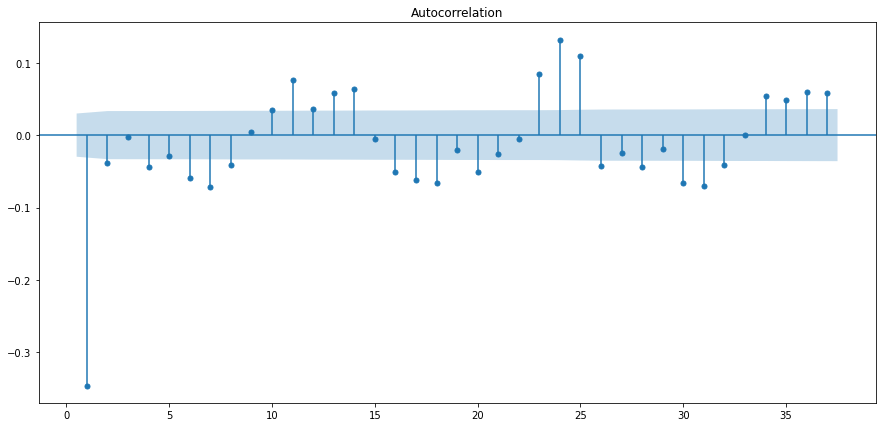

In [12]:
olsr_resid_diff_2 = olsr_resid_diff_1.diff()
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_2, alpha=0.05, zero=False, ax=ax)

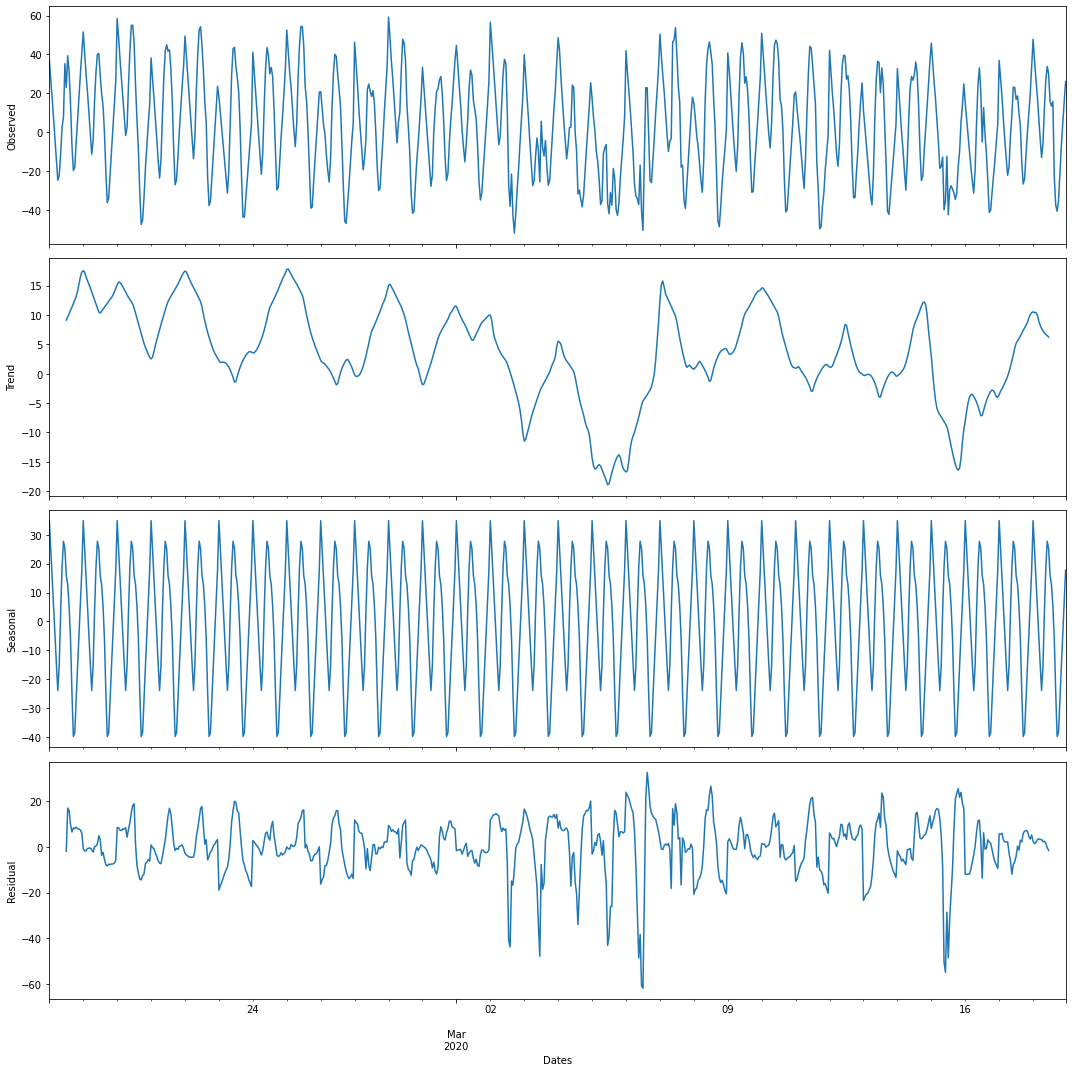

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

components = seasonal_decompose(olsr_results.resid[:720])

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,15))
plotseasonal(components, axes[:])
plt.tight_layout()

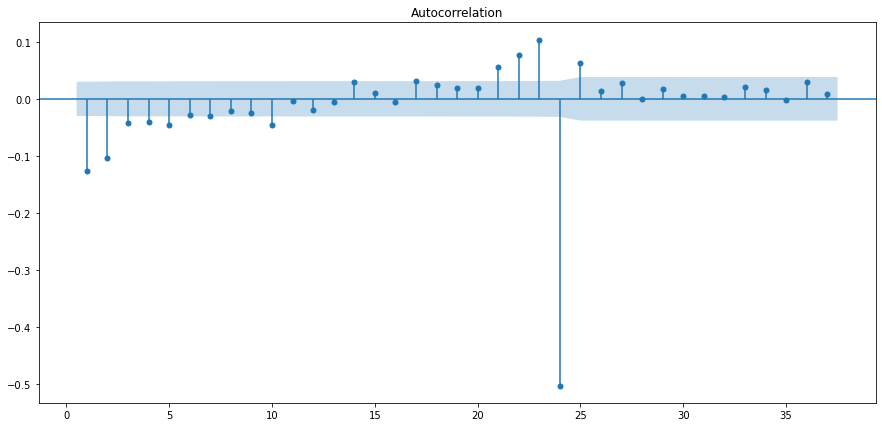

In [18]:
olsr_resid_diff_1_24 = olsr_resid_diff_1.diff(periods=24)
olsr_resid_diff_1_24 = olsr_resid_diff_1_24.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_1_24, alpha=0.05, zero=False, ax=ax)

In [19]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA

In [28]:
X_train = X_train.asfreq('H')
y_train = y_train.asfreq('H')
X_test = X_test.asfreq('H')
y_test = y_test.asfreq('H')

In [ ]:
sarimax_model = ARIMA(endog=y_train, order=(1,1,0), seasonal_order=(0,1,1,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

In [27]:
lag_hour = 24*3
y_test_hat = sarimax_results.get_forecast(steps=lag_hour)

print("Error metrics of 3 day test data")

RMSE = np.sqrt(mean_squared_error(y_test_hat.summary_frame()['mean'],y_test[:lag_hour]))
print("RMSE or Root mean squared error: %.2f" % RMSE)  

MAE = mean_absolute_error(y_test_hat.summary_frame()['mean'],y_test[:lag_hour])
print('Mean Absolute Error: %.2f' % MAE)

R2 = r2_score(y_test_hat.summary_frame()['mean'],y_test[:lag_hour])
print('Variance score: %.2f' % R2 )

Error metrics of 3 day test data
RMSE or Root mean squared error: 23.85
Mean Absolute Error: 13.09
Variance score: 0.65
